## Optimization :
   # Quadratic Programming
| Method | Relationship to Core Concept | Technique |
|:---|:---|:---|
| Active Set / SQP | `SLSQP` | Solves a sequence of QP subproblems to handle constraints. |
| Interior Point / PCG | `trust-constr` | Solves large linear systems using efficient iterative methods (like CG/PCG) during its trust-region minimization. |
| Dual Ascent (ADMM) | `OSQP`| Alternating Direction Method of Multipliers (ADMM)|

In [9]:
from utility.data_loader import load_parquet_data
from utility.data_transformer import transform_data
import utility.wt_comparision as wt_comparision
from pathlib import Path
import lib_optimizers.scipy_solvers as scipy_solvers
import lib_optimizers.osqp as osqp

In [10]:
faireness_coefficient = 0.5
regularization_coefficient=0.2

In [11]:
# Load the data
parquet_file_path = Path().absolute().parent / 'data' / 'breuninger_user_product_event_counts_000000000000'
my_data_df = load_parquet_data(str(parquet_file_path), engine='pyarrow')  

# Transform the data only if DataFrame is loaded successfully
if my_data_df is not None:
	data_for_optimization = transform_data(my_data_df, lambda_1=faireness_coefficient, lambda_2=regularization_coefficient)
else:
	raise ValueError("Failed to load data from parquet file")

In [12]:
hierarchy = [
    ('purchase', 'add_to_cart'),          # purchase >= add_to_cart
    ('add_to_cart', 'add_to_wishlist'),   # add_to_cart >= add_to_wishlist
    ('add_to_wishlist', 'product_view')   # add_to_wishlist >= product_view
]

# List to collect all weight vectors for comparison
all_weight_results = []


In [13]:

result = scipy_solvers.solve_constrained_quadratic(data_for_optimization['Q_solver'], data_for_optimization['c'], data_for_optimization['weight_names'], hierarchy=hierarchy,method='SLSQP')

all_weight_results.append({**result, 'weight_names': data_for_optimization['weight_names']})

print(f"Max Objective Score (f(w)): {result['max_f_w']}")
print(result['weights_df'])


Max Objective Score (f(w)): 87715.30260041586
     Weight          Feature
0  0.199186      add_to_cart
1  0.199382  add_to_wishlist
2  0.208599     product_view
3  0.199186         purchase
4  0.199708        view_cart


In [14]:

result = scipy_solvers.solve_constrained_quadratic(data_for_optimization['Q_solver'], data_for_optimization['c'], data_for_optimization['weight_names'], hierarchy=hierarchy,method='trust-constr')

all_weight_results.append({**result, 'weight_names': data_for_optimization['weight_names']})
print(f"Max Objective Score (f(w)): {result['max_f_w']}")
print(result['weights_df'])


Max Objective Score (f(w)): 90369.21013878148
         Weight          Feature
0  2.499999e-01      add_to_cart
1  2.499997e-01  add_to_wishlist
2  2.499996e-01     product_view
3  2.500000e-01         purchase
4  9.114964e-07        view_cart


In [15]:
result = osqp.minimizeUsingOsQP(data_for_optimization['Q_solver'], data_for_optimization['c'], data_for_optimization['weight_names'], hierarchy=hierarchy)

all_weight_results.append({**result, 'weight_names': data_for_optimization['weight_names']})
print(f"Max Objective Score (f(w)): {result['max_f_w']}")
print(result['weights_df'])

OSQP (ADMM) Optimal Weights (w*):
[('add_to_cart', np.float64(0.2499850402055159)), ('add_to_wishlist', np.float64(0.2500121534332511)), ('product_view', np.float64(0.250037387787551)), ('purchase', np.float64(0.2499677331521709)), ('view_cart', np.float64(-2.311194184046576e-06))]
OSQP Minimum Objective Value: -90380.49897833126
OSQP Status: solved
Max Objective Score (f(w)): 90380.49897833126
       Weight_Name  Optimal_Weight
0      add_to_cart        0.249985
1  add_to_wishlist        0.250012
2     product_view        0.250037
3         purchase        0.249968
4        view_cart       -0.000002


Visualization



--- Generating Final Score Comparison ---


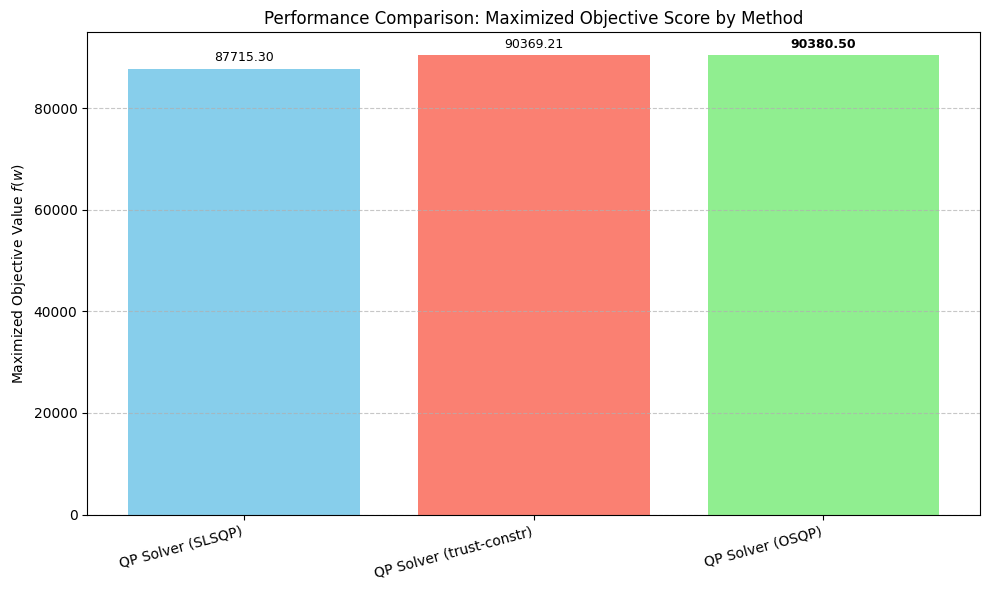

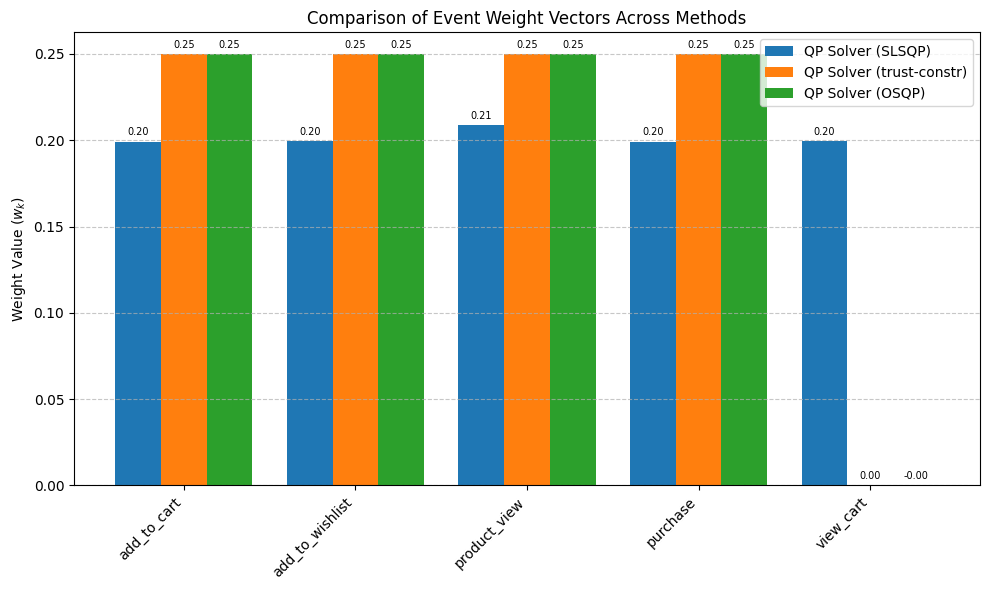


--- Best Optimization Method Found ---
Method: QP Solver (OSQP)
Max Objective Score (f(w)): 90380.4990

Weights for the Best Method:
                   Weight
Event                    
add_to_cart      0.249985
add_to_wishlist  0.250012
product_view     0.250037
purchase         0.249968
view_cart       -0.000002


In [16]:
#Visualize the Final Scores =
print("\n\n--- Generating Final Score Comparison ---")
wt_comparision.visualize(data_for_optimization,all_weight_results)